In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Create and connect to the database
conn = sqlite3.connect('sales_data.db')
cursor = conn.cursor()

# Create sales table
cursor.execute('''
CREATE TABLE IF NOT EXISTS sales (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    product TEXT,
    quantity INTEGER,
    price REAL,
    sale_date TEXT
)
''')

# Insert sample data with dates
sales_data = [
    ('Laptop', 5, 999.99, '2023-01-15'),
    ('Phone', 10, 699.99, '2023-01-16'),
    ('Tablet', 7, 349.99, '2023-01-16'),
    ('Laptop', 3, 999.99, '2023-01-17'),
    ('Phone', 8, 699.99, '2023-01-18'),
    ('Monitor', 4, 249.99, '2023-01-18'),
    ('Keyboard', 12, 49.99, '2023-01-19'),
    ('Mouse', 15, 29.99, '2023-01-20')
]

cursor.executemany('INSERT INTO sales (product, quantity, price, sale_date) VALUES (?, ?, ?, ?)', sales_data)

# Save changes and close connection
conn.commit()
conn.close()

print("Database created with sample data!")

Database created with sample data!


In [3]:
# Reconnect to the database
conn = sqlite3.connect('sales_data.db')

# Query 1: Product sales summary
product_summary = pd.read_sql('''
    SELECT 
        product, 
        SUM(quantity) AS total_quantity,
        SUM(quantity * price) AS revenue,
        ROUND(AVG(price), 2) AS avg_price
    FROM sales
    GROUP BY product
    ORDER BY revenue DESC
''', conn)

# Query 2: Daily sales
daily_sales = pd.read_sql('''
    SELECT 
        sale_date,
        SUM(quantity) AS daily_quantity,
        SUM(quantity * price) AS daily_revenue
    FROM sales
    GROUP BY sale_date
    ORDER BY sale_date
''', conn)

# Query 3: Overall metrics
overall_stats = pd.read_sql('''
    SELECT 
        SUM(quantity) AS total_quantity,
        SUM(quantity * price) AS total_revenue,
        COUNT(DISTINCT product) AS unique_products,
        MIN(sale_date) AS first_sale,
        MAX(sale_date) AS last_sale
    FROM sales
''', conn)

# Close connection
conn.close()

# Display results
print("=== PRODUCT SALES SUMMARY ===")
display(product_summary)

print("\n=== DAILY SALES ===")
display(daily_sales)

print("\n=== OVERALL STATS ===")
display(overall_stats)

=== PRODUCT SALES SUMMARY ===


,product,total_quantity,revenue,avg_price
0,Phone,18,12599.82,699.99
1,Laptop,8,7999.92,999.99
2,Tablet,7,2449.93,349.99
3,Monitor,4,999.96,249.99
4,Keyboard,12,599.88,49.99
5,Mouse,15,449.85,29.99



=== DAILY SALES ===


,sale_date,daily_quantity,daily_revenue
0,2023-01-15,5,4999.95
1,2023-01-16,17,9449.83
2,2023-01-17,3,2999.97
3,2023-01-18,12,6599.88
4,2023-01-19,12,599.88
5,2023-01-20,15,449.85



=== OVERALL STATS ===


,total_quantity,total_revenue,unique_products,first_sale,last_sale
0,64,25099.36,6,2023-01-15,2023-01-20


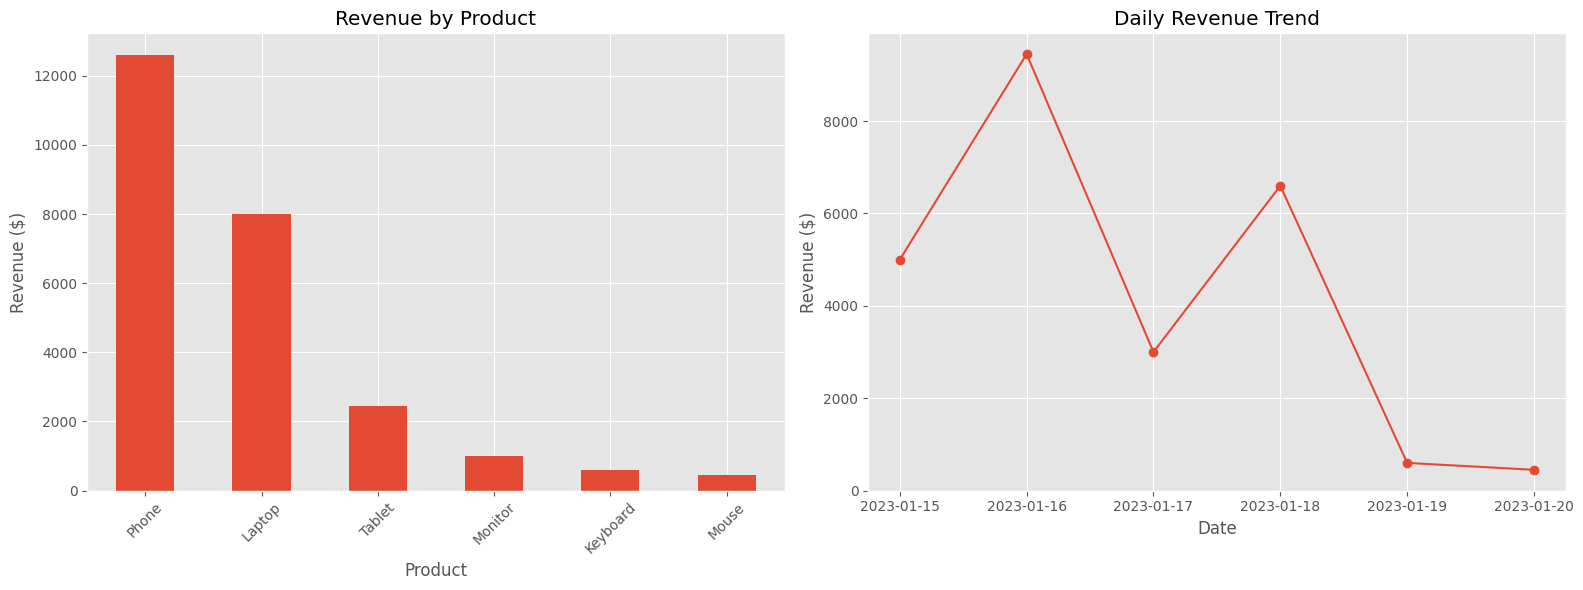

Chart saved as 'sales_analysis.png'


In [4]:
# Set style for plots
plt.style.use('ggplot')

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Product Revenue Bar Chart
product_summary.plot(kind='bar', x='product', y='revenue', ax=ax1, legend=False)
ax1.set_title('Revenue by Product')
ax1.set_ylabel('Revenue ($)')
ax1.set_xlabel('Product')
ax1.tick_params(axis='x', rotation=45)

# Daily Revenue Line Chart
daily_sales.plot(kind='line', x='sale_date', y='daily_revenue', 
                 marker='o', ax=ax2, legend=False)
ax2.set_title('Daily Revenue Trend')
ax2.set_ylabel('Revenue ($)')
ax2.set_xlabel('Date')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Save figures
fig.savefig('sales_analysis.png', dpi=300, bbox_inches='tight')
print("Chart saved as 'sales_analysis.png'")

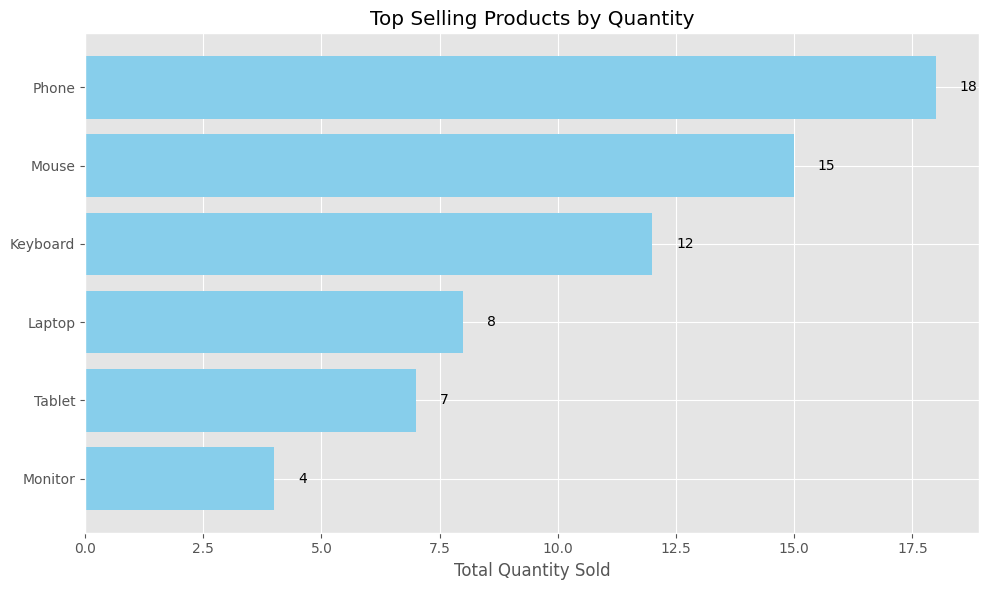

In [12]:
# Get top products by quantity sold
top_products = product_summary.sort_values('total_quantity', ascending=False)

# Visualization
plt.figure(figsize=(10, 6))
plt.barh(top_products['product'], top_products['total_quantity'], color='skyblue')
plt.title('Top Selling Products by Quantity')
plt.xlabel('Total Quantity Sold')
plt.gca().invert_yaxis()  # Highest on top
for i, v in enumerate(top_products['total_quantity']):
    plt.text(v + 0.5, i, str(v), va='center')
plt.tight_layout()
plt.show()

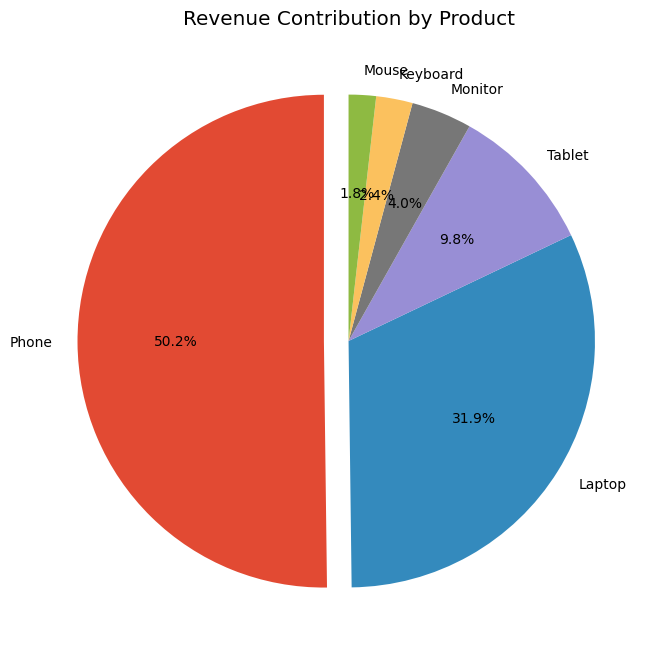

In [13]:
# Calculate percentage contribution
product_summary['revenue_pct'] = (product_summary['revenue'] / product_summary['revenue'].sum()) * 100

# Visualization
plt.figure(figsize=(8, 8))
plt.pie(product_summary['revenue_pct'], 
        labels=product_summary['product'],
        autopct='%1.1f%%',
        startangle=90,
        explode=[0.1 if max(product_summary['revenue_pct']) == x else 0 for x in product_summary['revenue_pct']])
plt.title('Revenue Contribution by Product')
plt.show()

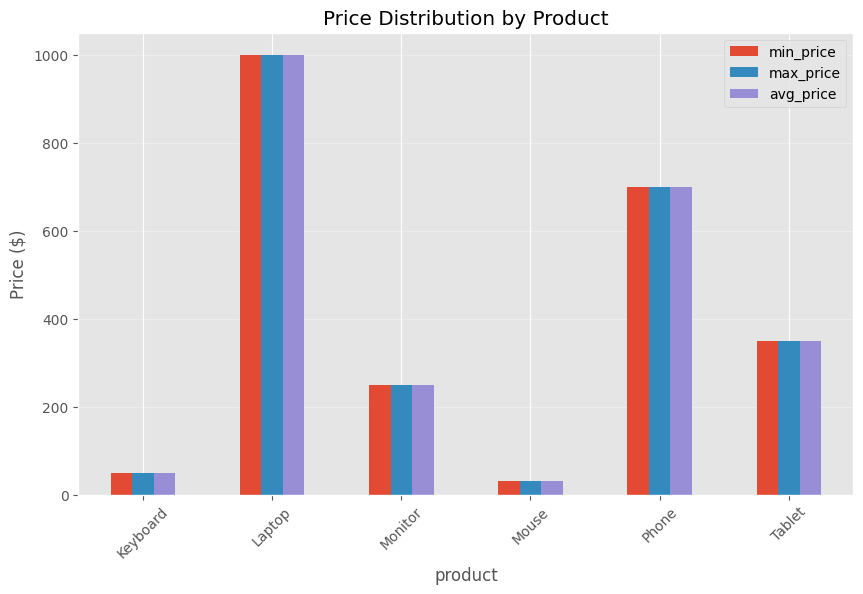

In [14]:
# Get price distribution
price_stats = pd.read_sql("""
    SELECT 
        product,
        MIN(price) AS min_price,
        MAX(price) AS max_price,
        AVG(price) AS avg_price
    FROM sales
    GROUP BY product
""", sqlite3.connect('sales_data.db'))

# Visualization
price_stats.set_index('product').plot(kind='bar', figsize=(10, 6))
plt.title('Price Distribution by Product')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

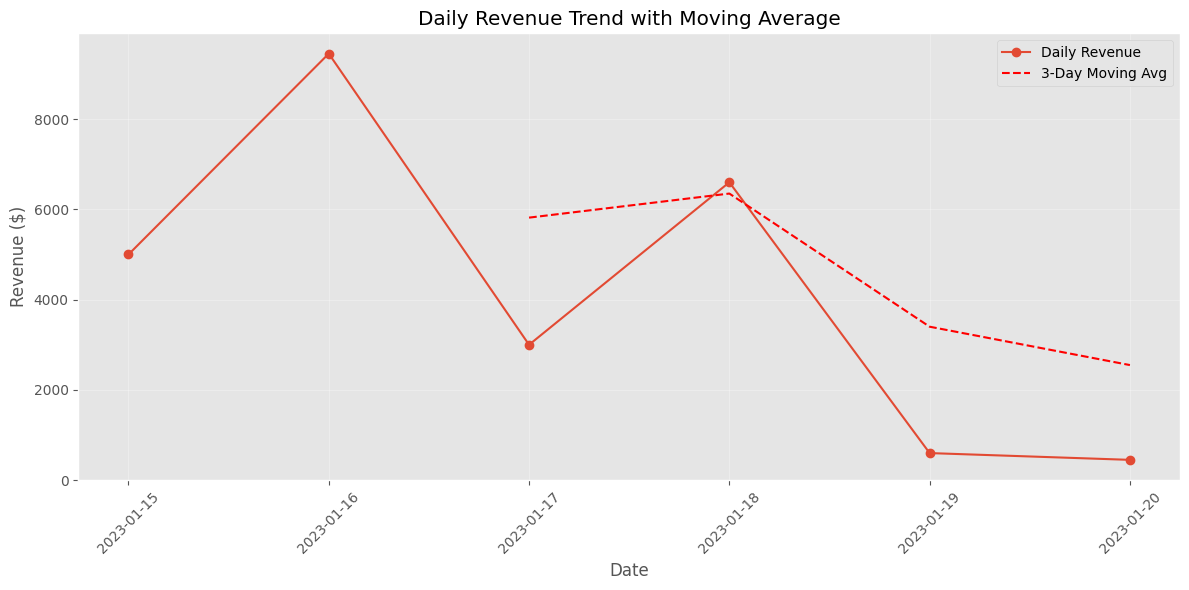

In [15]:
# Convert to datetime and calculate 3-day moving average
daily_sales['sale_date'] = pd.to_datetime(daily_sales['sale_date'])
daily_sales['moving_avg'] = daily_sales['daily_revenue'].rolling(window=3).mean()

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(daily_sales['sale_date'], daily_sales['daily_revenue'], 'o-', label='Daily Revenue')
plt.plot(daily_sales['sale_date'], daily_sales['moving_avg'], 'r--', label='3-Day Moving Avg')
plt.title('Daily Revenue Trend with Moving Average')
plt.ylabel('Revenue ($)')
plt.xlabel('Date')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

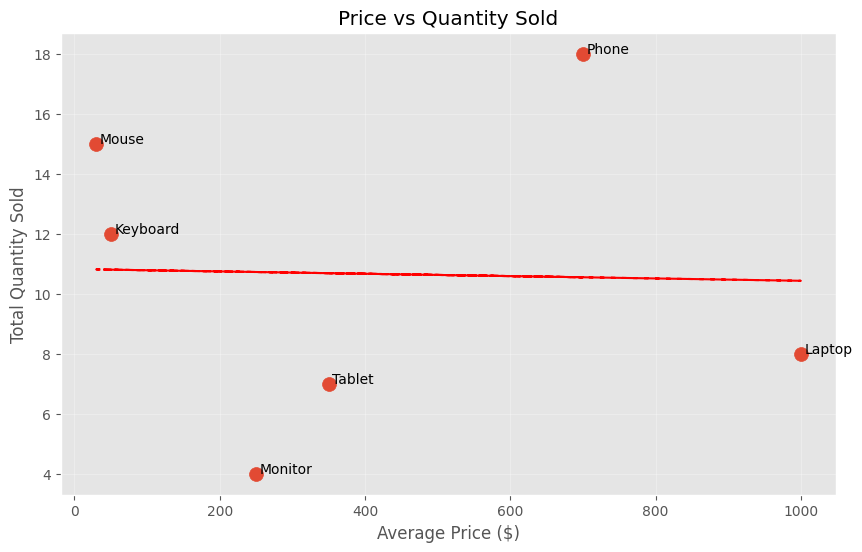

In [16]:
# Get price-quantity relationship
price_qty = pd.read_sql("""
    SELECT 
        product,
        AVG(price) AS avg_price,
        SUM(quantity) AS total_quantity
    FROM sales
    GROUP BY product
""", sqlite3.connect('sales_data.db'))

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(price_qty['avg_price'], price_qty['total_quantity'], s=100)

# Add labels and trendline
for i, row in price_qty.iterrows():
    plt.text(row['avg_price']+5, row['total_quantity'], row['product'])
    
z = np.polyfit(price_qty['avg_price'], price_qty['total_quantity'], 1)
p = np.poly1d(z)
plt.plot(price_qty['avg_price'], p(price_qty['avg_price']), "r--")

plt.title('Price vs Quantity Sold')
plt.xlabel('Average Price ($)')
plt.ylabel('Total Quantity Sold')
plt.grid(alpha=0.3)
plt.show()

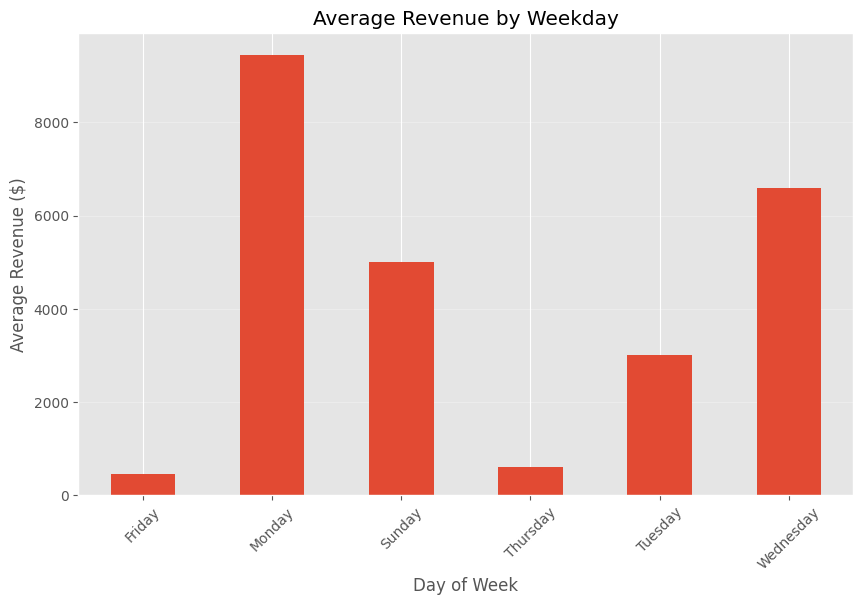

In [18]:
# Extract weekday from dates
daily_sales['weekday'] = daily_sales['sale_date'].dt.day_name()

# Visualization
plt.figure(figsize=(10, 6))
daily_sales.groupby('weekday')['daily_revenue'].mean().plot(kind='bar')
plt.title('Average Revenue by Weekday')
plt.ylabel('Average Revenue ($)')
plt.xlabel('Day of Week')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

In [19]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Connect to database
conn = sqlite3.connect('sales_data.db')

# Get basic product summary (ensure this matches what you have)
product_summary = pd.read_sql("""
    SELECT 
        product, 
        SUM(quantity) AS total_quantity,
        SUM(quantity * price) AS revenue,
        AVG(price) AS avg_price
    FROM sales
    GROUP BY product
""", conn)

# Get price statistics (now included in the query above)
price_stats = pd.read_sql("""
    SELECT 
        product,
        MIN(price) AS min_price,
        MAX(price) AS max_price,
        AVG(price) AS avg_price
    FROM sales
    GROUP BY product
""", conn)

# Close connection
conn.close()

# Create comprehensive summary table (fixed version)
summary_table = product_summary.merge(price_stats, on='product', suffixes=('', '_y'))
summary_table = summary_table.loc[:,~summary_table.columns.duplicated()]  # Remove duplicate columns
summary_table['avg_sale_value'] = summary_table['revenue'] / summary_table['total_quantity']

# Select only the columns we actually have
available_columns = [col for col in ['product', 'total_quantity', 'revenue', 
                   'avg_price', 'min_price', 'max_price', 'avg_sale_value'] 
                   if col in summary_table.columns]
summary_table = summary_table[available_columns]

# Format for display
def currency_format(x):
    return f"${x:,.2f}" if isinstance(x, (int, float)) else x

display_table = summary_table.copy()
for col in ['revenue', 'avg_price', 'min_price', 'max_price', 'avg_sale_value']:
    if col in display_table.columns:
        display_table[col] = display_table[col].apply(currency_format)

print("Comprehensive Sales Summary:")
display(display_table.style.set_properties(**{'text-align': 'center'}))

Comprehensive Sales Summary:


,product,total_quantity,revenue,avg_price,min_price,max_price,avg_sale_value
0,Keyboard,12,$599.88,$49.99,$49.99,$49.99,$49.99
1,Laptop,8,"$7,999.92",$999.99,$999.99,$999.99,$999.99
2,Monitor,4,$999.96,$249.99,$249.99,$249.99,$249.99
3,Mouse,15,$449.85,$29.99,$29.99,$29.99,$29.99
4,Phone,18,"$12,599.82",$699.99,$699.99,$699.99,$699.99
5,Tablet,7,"$2,449.93",$349.99,$349.99,$349.99,$349.99
